!pip install torchmetricsPerform CIFAR10 classification using Neural Netwroks and Convolutional Neural Networks.

1) Use 10 iterations for training


2) Show the training loss for both networks on the same plot


3) Compare the test loss and accuracy.

In [2]:
!pip install torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchmetrics as tm




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 6.7 MB/s 


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# CIFAR10
def cifar10(batch_sz, path='./datasets'):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(32, padding=4), # Increase the number of samples by moving the images around 
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = CIFAR10(root=path, train=True, download=True, transform=transform_train) # 
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz,
                                               shuffle=True, pin_memory=True)

    # Test dataset
    test_data = CIFAR10(root=path, train=False, download=False, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes


In [5]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, test_loader, _=cifar10(batch_sz) 

tl = iter(train_loader)
batch = next(tl)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


In [6]:
def show_image(batch,img):
    return plt.imshow(np.transpose(batch[0][img,:,:,:],(1,2,0)))

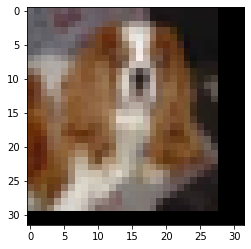

In [7]:
show_image(batch,7)

In [19]:
# Define the Class 
# Regular 
class NNet(nn.Module):
    def __init__(self, input_size=3072, output_size=10, no_hidden_layers=5,hidden_layer_size=1024) -> None:
        super(NNet,self).__init__()
        self.deep_nn = nn.Sequential()
        
        for i in range(no_hidden_layers):
            self.deep_nn.add_module(f'ff{i}', nn.Linear(input_size,hidden_layer_size))
            self.deep_nn.add_module(f'activation{i}',nn.ReLU())
            input_size = hidden_layer_size

        self.deep_nn.add_module(f'classifier',nn.Linear(hidden_layer_size,output_size))

    def forward(self, x):
        tensor = self.deep_nn(x)
        return tensor


# CNN

class CNN(nn.Module):
    def __init__(self, in_channels=3,num_classes=10) -> None:
        super(CNN,self).__init__() # In the other tutorial he is using CNN and self within the super(CNN, self) brakets

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3),stride=(1,1),padding=(1,1))  #  3 -1 /2 ; 3 being the filter_size, with padding the image size stays the same
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),stride=(1,1),padding=(1,1))



        self.maxpool = nn.MaxPool2d(kernel_size= (2,2), stride= (2,2))

        self._in = nn.Linear(256*4*4, 1024)
        self.h1 = nn.Linear(1024,512) # remove and adjust dims to recover AC2
        self.lin_out = nn.Linear(512,num_classes) 

    # Forward Pass
    
    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.maxpool(x)

        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.maxpool(x)

        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.maxpool(x)

        # Linear Model
        x = x.reshape(x.shape[0], -1)
        x = torch.relu(self._in(x))
        x = torch.relu(self.h1(x))
        x = self.lin_out(x)
            
        return x


In [9]:
# Dim test

def dim_test(model,dim,channel,x1,x2):
    model = model.to(device=device)
    x = torch.randn(dim,channel,x1,x2)
    return model(x).shape

In [10]:
model = CNN().to(device)



In [33]:
# Hyperparameter

inputs = 3*32*32
mm = 0
batch_sz=64
epoch_no = 10
mini_batches = [64]
learning_rates = [0.05]


In [30]:
def var_training(model=CNN(),type_CNN = True):
    for mini_batch in mini_batches:
        for learning_rate in learning_rates:
            print(f'the learning rate is the {learning_rate}.')
            model_2 = model.to(device=device)
        
            # write to tensorboard
            step = 0

            if type_CNN == True:
                writer = SummaryWriter(f'./runs/CIFAR10/CNN_bs={mini_batch}_lr={learning_rate}')
            else:
                writer = SummaryWriter(f'./runs/CIFAR10/NN_bs={mini_batch}_lr={learning_rate}')


            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model_2.parameters(), lr=learning_rate, momentum= mm)
            scheduler = None

            # generate new data
            train_loader, test_loader, _=cifar10(mini_batch) 

            
            for epoch in range(epoch_no):
                train_loss = 0
                for batch_idx, (data, targets) in enumerate(train_loader):
                    data = data.to(device=device)
                    targets = targets.to(device=device)

                    if type_CNN == False:
                        data = data.reshape(data.shape[0], -1)
                    else:
                        pass

                    # forwards
                    logits = model_2(data)
                    loss = criterion(logits, targets)
                    train_loss += loss.item()


                    # backward 
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    # scbeduler.step()

                    # Running Accuracy
                    _, predictions = logits.max(1)
                    num_corr = (predictions == targets).sum()
                    running_acc = float(num_corr)/float(data.shape[0])
                    
                    writer.add_scalar("Training Loss", loss, global_step = step) 
                    writer.add_scalar("Training Accuracy", running_acc, global_step=step)
                    step += 1  


            acc_l = []

            accuracy = tm.Accuracy()

            with torch.no_grad():
                step_2 = 0
                for batch_idx, (data, targets) in enumerate(test_loader):
                    data = data.to(device=device)
                    targets = targets.to(device=device)

                    if type_CNN == False:
                        data = data.reshape(data.shape[0], -1)
                    else:
                        pass

                    logits = model_2(data)
                    t_loss = criterion(logits, targets)
                    train_loss += loss.item()

                    yhat = torch.argmax(logits, axis =1)

                    acc = accuracy(yhat.to("cpu"),targets.to("cpu"))

                    acc_l.append(acc)

                    writer.add_scalar("Testing Loss", t_loss, global_step = step_2) 
                    writer.add_scalar("Testing Accuracy", acc, global_step=step_2)
                    step_2 += 1

            print(f'the accuracy on the test set for the batch size {mini_batch} and {learning_rate} is {np.mean(acc_l)}')

In [ ]:
var_training(model=CNN(),type_CNN=True)

the learning rate is the 0.05.
Files already downloaded and verified


# Results

In this homework different learning rates were analysed and evaluated. Specifically, the learning rates 0.001, 0.05, 0.1, 0.15 have been used for training and testing. 

![Training Accuracy](/Training_Accuracy_HW2.png)